## Defining Benchmark Functions

In [260]:
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# function we are attempting to optimize
def rastrigins(x):
    err = 0
    for i in range(len(x)):
        err += (x[i]**2) - (10 * math.cos(2 * math.pi * x[i])) + 10
    return err

def shifted_sphere(x):
    err=0
    for i in range(len(x)):
        err+=x[i]**2
    return err

def shifted_schwefel(x):
    finerr=0
    for i in range(len(x)):
        err=0
        for j in range(0,i+1):
            err+=x[j]          
        err=err*err
        finerr+=err    
    return finerr

def shifted_Rosenbrock(x):
    err=0
    for i in range(len(x)-1):
        err+=100*pow((x[i]**2-x[i+1]),2)+pow((x[i]-1),2)        
    return err

def shifted_Griewanks(x):
    err=0
    sum_term=0
    pro_term=1
    for i in range(len(x)):
        sum_term+=(x[i]**2)/4000
        pro_term*=math.cos(x[i]/((i+1)**0.5))#i+1, considering the indices starts from 1 
    err=sum_term-pro_term+1 
    return err

## Creating Class for PSO

In [279]:
#Particle class

class Particle:
    def __init__(self,x):
        self.position=[]         # particle position
        self.velocity=[]         # particle velocity
        self.pBest=[]            # personal best position
        self.errBest=math.inf          # personal best error
        self.myErr=math.inf            # current error

        for i in range(0,num_dimensions):
            self.velocity.append(random.uniform(-1,1))#initialising velocity
            self.position.append(x[i])                #initialising position of each particle
            

    # obtaining current fitness
    def find_fitness(self,cFunc):
        self.myErr=cFunc(self.position)

        # checking if the current position is the best
        if self.myErr < self.errBest:
            self.pBest=self.position
            self.errBest=self.myErr
           

    # update velocity
    def update_velocity(self,gBest,lBest):
        w = 0.7    # inertia weight
        c1 = 2  # for cognitive component
        c2 = 2  # for social component
        c3 = 2 #informants component
        for i in range(0,num_dimensions):
            r1=random.uniform(0,1)
            r2=random.uniform(0,1)
            r3=random.uniform(0,1)
            cognitive_comp=c1*r1*(self.pBest[i]-self.position[i])
            social_comp=c2*r2*(gBest[i]-self.position[i])
            local_comp=c3*r3*(lBest[i]-self.position[i])
            
            self.velocity[i]=w*self.velocity[i]+cognitive_comp+social_comp+local_comp

    # update the position of particle with new velocity
    def update_position(self):
        for i in range(0,num_dimensions):
            self.position[i]=self.position[i]+self.velocity[i]
           
            
#Collective Swarm Class
                
class PSO():
    def __init__(self,cFunc,popn,maxiter):
        global num_dimensions
        self.popn=popn
        self.num_particles=popn.shape[0]
        num_dimensions=popn.shape[1]
        self.informants=4
        self.cFunc=cFunc
        self.err_best_g=math.inf        # best error in the group
        gBest=[]                   # best position from the group
        lBest=[]
        #Create the swarm
        self.swarm=[]
        self.maxiter=maxiter
        for i in range(0,self.num_particles):
            #initialising the position of each particles randomly
            self.swarm.append(Particle(popn[i]))
    def start_opt_PSO(self):
        # start optimization process
        i=0
        BestError=[]
        while i < self.maxiter:
            if(i!=0):
                BestError.append(self.err_best_g)
            if i % 100 == 0 and i > 1:
                print("Epoch = " + str(i) +" Global Best error=", self.err_best_g)
                #print ("Epoch:"i,err_best_g)
            # cycle through particles and obtain fitness
            for j in range(0,self.num_particles):
                self.swarm[j].find_fitness(self.cFunc)
                
                # check whether current particle is the best (globally)
                if self.swarm[j].myErr < self.err_best_g:
                    gBest=list(self.swarm[j].position)
                    self.err_best_g=float(self.swarm[j].myErr)

            # cycle through swarm particles and update velocities and position
            for j in range(0,self.num_particles):
                lBest=self.local_best(self.informants,self.cFunc,self.swarm[j])
                self.swarm[j].update_velocity(gBest,lBest)
                self.swarm[j].update_position()
            i+=1

        print('Final Global Best Position And Corresponding Error:')
        print (gBest)
        print (self.err_best_g)
        return BestError
    
    #Function for obtaining informants best    
    def local_best(self,n,cFunc,swarmp):
        neighbor=[]
        neighbor_fitness=[]
        for i in range(len(self.swarm)):
            distance=[]
            for j,p in enumerate(self.swarm):
                distance.append([sum(np.abs([y-x for x,y in zip(p.position,swarmp.position)])),j])
            distance.sort()
            distance=distance[0:n+1]
            neighbor_fitness=[cFunc(self.swarm[j[1]].position) for j in distance]
            neighbor=[self.swarm[j[1]].position for j in distance]
            lBest_idx = np.where(neighbor_fitness == np.min(neighbor_fitness))
            lBest=neighbor[lBest_idx[0][0]]  
        return lBest         

## Creating Class for GA

In [240]:
#For Coursework
import numpy
class GA:
    def __init__(self,cFunc,popn,num_gen,num_parent):
        self.cFunc=cFunc
        self.popn=popn
        self.num_gen=num_gen
        self.n_parents_mating=num_parent
        self.dim=self.popn.shape[1]
        
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
    def calculate_fitness(self,cFunc,pop):

    # Calculating the fitness value of each solution in the current population.
        fitness=[]
        if(cFunc=='rastrigins'):
            for p in pop:
                fitness.append(rastrigins(p))
        elif(cFunc=='shifted_sphere'):
            for p in pop:
                fitness.append(shifted_sphere(p))
        elif(cFunc=='shifted_schwefel'):
            for p in pop:
                fitness.append(shifted_schwefel(p))
        elif(cFunc=='shifted_Griewanks'):
            for p in pop:
                fitness.append(shifted_Griewanks(p))
        elif(cFunc=='shifted_Rosenbrock'):
            for p in pop:
                fitness.append(shifted_Rosenbrock(p))
        return fitness


    def tournament(self,fitness,pop,num_parents):
        parents = numpy.empty((num_parents, pop.shape[1]))
        for parent_num in range(num_parents):
            fitness_idx = numpy.where(fitness == numpy.min(fitness))
            fitness_idx = fitness_idx[0][0]
            parents[parent_num, :] = pop[fitness_idx, :]
            fitness[fitness_idx] = math.inf
        return parents    
        
    
    def two_point_crossover(self,parents, offspring_size):
        offspring = np.empty(offspring_size)
        # Selecting the point at which crossover occurs between two parents.Normally it is at center.
        crossover_point1 = random.randint(0,parents.shape[1])
        crossover_point2 =random.randint(0,parents.shape[1])
        if(crossover_point1>crossover_point2):
            t=crossover_point2
            crossover_point2=crossover_point1
            crossover_point1=t
        idx=0
        for k in range(numpy.uint8(offspring_size[0]/2)):
            # Index of the first parent to mate.
            parent1_idx = idx

            # Index of the second parent to mate.
            parent2_idx = idx+1

            # The first offspring will have its middle half of its genes taken from the second parent.
            offspring[idx, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
            offspring[idx, crossover_point1:crossover_point2] = parents[parent2_idx,crossover_point1:crossover_point2]
            offspring[idx,crossover_point2:] = parents[parent1_idx, crossover_point2:]
            # The second offspring will have its middle half of its genes taken from the first parent.
            offspring[idx+1, 0:crossover_point1] = parents[parent2_idx, 0:crossover_point1]
            offspring[idx+1, crossover_point1:crossover_point2] = parents[parent1_idx,crossover_point1:crossover_point2]
            offspring[idx+1, crossover_point2:] = parents[parent2_idx, crossover_point2:]
            idx=idx+2
        return offspring

    def mutation(self,offspring_crossover,generation,n):  
        #Mutation changes a selected genes in each offspring randomly.
        for idx in range(offspring_crossover.shape[0]):
            #The random value to be added to the gene.
            random_value =numpy.random.uniform(-1.0, 1.0, 1)
            rand_idx=random.randint(0,offspring_crossover.shape[1]-1)
            
            offspring_crossover[idx,rand_idx:] = offspring_crossover[idx, rand_idx:]-random_value
        return offspring_crossover
    def start_opt_GA(self):
        Error=[]
        for generation in range(self.num_gen):
            fitness=self.calculate_fitness(self.cFunc,self.popn)
            parents=self.tournament(fitness,self.popn,self.n_parents_mating)
   
            # Getting next generation by crossover.
            offspring_crossover = self.two_point_crossover(parents,offspring_size=(self.popn.shape[0]-parents.shape[0],self.dim))

            # Mutation of the offspring.
            offspring_mutation =self.mutation(offspring_crossover,generation,self.num_gen)

            #Creating new population of offsprings
            self.popn[0:parents.shape[0], :] = parents
            self.popn[parents.shape[0]:, :] = offspring_mutation

            # The best result in the current generation.
            err=np.min(self.calculate_fitness(self.cFunc,self.popn))
            Error.append(err)
            if(generation%100==0):
                print("Best result in generation {0} is {1}".format(generation,err ))
            # Getting the best solution in final generation.
        fitness = self.calculate_fitness(self.cFunc,self.popn)

        # Return the index of the solution with the best fitness.
        best_match_idx = np.where(fitness == np.min(fitness))
        best_match_idx = best_match_idx[0][0]
        print("Best solution : ", self.popn[best_match_idx, :])
        print("Best solution fitness : ", fitness[best_match_idx])
        return Error


## Initializing Population with Size=20,Dimension=10

In [219]:
np.random.seed(59)
population=np.random.uniform(low=-10.0, high=10.0, size=(20,10))

In [220]:
from copy import copy
init_pop=copy(population)

## Shifted Sphere Function PSO

Starting PSO:
Epoch = 100 Global Best error= 32.99897905432874
Epoch = 200 Global Best error= 6.764230454206506
Epoch = 300 Global Best error= 2.7219778454632118
Epoch = 400 Global Best error= 0.8560330018816775
Epoch = 500 Global Best error= 0.031011559991466733
Epoch = 600 Global Best error= 0.0176141369279382
Epoch = 700 Global Best error= 0.011442874010124733
Epoch = 800 Global Best error= 0.0007953008011587911
Epoch = 900 Global Best error= 0.00012791247441165343
Epoch = 1000 Global Best error= 1.333706745080913e-05
Epoch = 1100 Global Best error= 1.2281002493878606e-05
Epoch = 1200 Global Best error= 6.287153726772272e-06
Epoch = 1300 Global Best error= 1.6453709497554885e-06
Epoch = 1400 Global Best error= 1.094929720831341e-06
Epoch = 1500 Global Best error= 5.460087523291381e-08
Epoch = 1600 Global Best error= 1.4184977627058132e-08
Epoch = 1700 Global Best error= 2.0339494801250905e-09
Epoch = 1800 Global Best error= 4.90393502418216e-10
Epoch = 1900 Global Best error= 1.6670

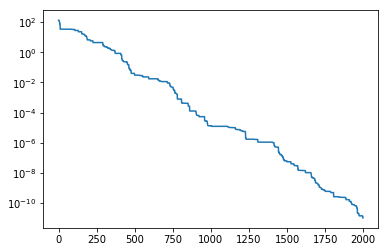

In [146]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_sphere,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## Shifted Sphere Function GA

Starting GA:
Best result in generation 0 is 121.17442820856719
Best result in generation 100 is 0.018249675024726148
Best result in generation 200 is 0.005349197092561396
Best result in generation 300 is 0.0022211974105621067
Best result in generation 400 is 0.0013557526449611442
Best result in generation 500 is 0.0011307902432431604
Best result in generation 600 is 0.0007827155800210597
Best result in generation 700 is 0.0005942219657315454
Best result in generation 800 is 0.00045363070817161847
Best result in generation 900 is 0.0004153028947359495
Best result in generation 1000 is 0.0003902809565920625
Best result in generation 1100 is 0.0003561508170319644
Best result in generation 1200 is 0.00021325798952411356
Best result in generation 1300 is 0.00017897466542167028
Best result in generation 1400 is 0.00016226077905089544
Best result in generation 1500 is 5.102361584763301e-05
Best result in generation 1600 is 4.780811670025675e-05
Best result in generation 1700 is 4.780811670025

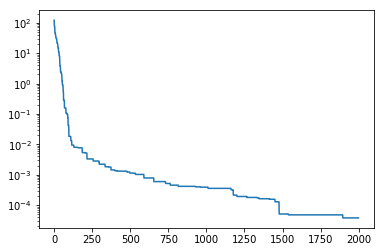

In [147]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_sphere'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

## Comparison of shifted sphere in PSO and GA

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


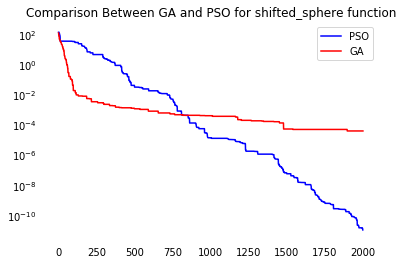

In [148]:
fig,ax=plt.subplots()

ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Schwefel Function PSO

Starting PSO:
Epoch = 100 Global Best error= 63.51082447250597
Epoch = 200 Global Best error= 63.51082447250597
Epoch = 300 Global Best error= 61.39370779404007
Epoch = 400 Global Best error= 29.76681466510365
Epoch = 500 Global Best error= 11.828212485396428
Epoch = 600 Global Best error= 7.128828950929447
Epoch = 700 Global Best error= 0.6703213655912591
Epoch = 800 Global Best error= 0.6703213655912591
Epoch = 900 Global Best error= 0.20176896651628873
Epoch = 1000 Global Best error= 0.11729183136394114
Epoch = 1100 Global Best error= 0.11729183136394114
Epoch = 1200 Global Best error= 0.08142034868928291
Epoch = 1300 Global Best error= 0.034413974236443844
Epoch = 1400 Global Best error= 0.005561277127373377
Epoch = 1500 Global Best error= 0.0011752178812011666
Epoch = 1600 Global Best error= 0.0003880861808737689
Epoch = 1700 Global Best error= 0.00018121683896133706
Epoch = 1800 Global Best error= 0.00018121683896133706
Epoch = 1900 Global Best error= 0.00011125254577034675
Final

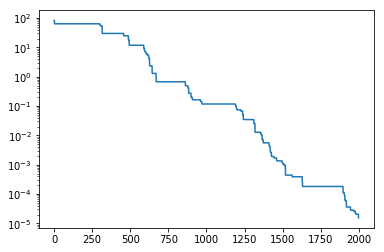

In [157]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_schwefel,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## Shifted Schwefel Function GA

Starting GA:
Best result in generation 0 is 83.93673811002523
Best result in generation 100 is 6.0977836730615484
Best result in generation 200 is 3.1073297581337016
Best result in generation 300 is 1.1433711206235668
Best result in generation 400 is 0.863593238240515
Best result in generation 500 is 0.3697911159716331
Best result in generation 600 is 0.23532905294585155
Best result in generation 700 is 0.22298599173864753
Best result in generation 800 is 0.17142762912771373
Best result in generation 900 is 0.07027657216371036
Best result in generation 1000 is 0.059240822090118016
Best result in generation 1100 is 0.053157814868189074
Best result in generation 1200 is 0.04530701394344528
Best result in generation 1300 is 0.034111008389767376
Best result in generation 1400 is 0.034111008389767376
Best result in generation 1500 is 0.03255533670933925
Best result in generation 1600 is 0.02795395134522673
Best result in generation 1700 is 0.027681880684572453
Best result in generation 1800

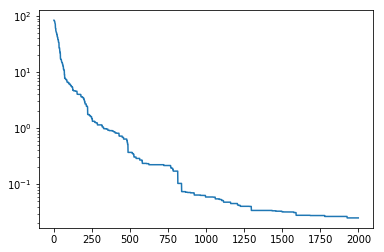

In [155]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_schwefel'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

## Comparison of Shifted schwefel in PSO and GA

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


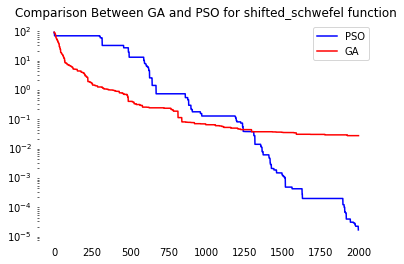

In [158]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Rastrigin's Function PSO

Starting PSO:
Epoch = 100 Global Best error= 59.4643588680544
Epoch = 200 Global Best error= 32.032310116044144
Epoch = 300 Global Best error= 28.1093589115469
Epoch = 400 Global Best error= 25.276206067395186
Epoch = 500 Global Best error= 17.514351413790965
Epoch = 600 Global Best error= 13.996753459488966
Epoch = 700 Global Best error= 13.996753459488966
Epoch = 800 Global Best error= 12.50287942283349
Epoch = 900 Global Best error= 12.132188214129702
Epoch = 1000 Global Best error= 9.070430366048507
Epoch = 1100 Global Best error= 7.511114695115218
Epoch = 1200 Global Best error= 6.6896991585553245
Epoch = 1300 Global Best error= 6.178474105595937
Epoch = 1400 Global Best error= 4.099190674562259
Epoch = 1500 Global Best error= 4.099190674562259
Epoch = 1600 Global Best error= 4.0185064833694994
Epoch = 1700 Global Best error= 3.9886418664593446
Epoch = 1800 Global Best error= 3.1709670948622204
Epoch = 1900 Global Best error= 3.0249947377797977
Final Global Best Position And Corre

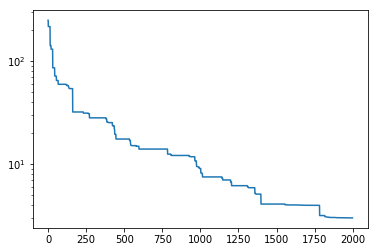

In [197]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(rastrigins,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## Shifted Rastrigins Function GA

Starting GA:
Best result in generation 0 is 238.35756815685033
Best result in generation 100 is 23.46700870061055
Best result in generation 200 is 4.434323061538322
Best result in generation 300 is 0.7075683015777123
Best result in generation 400 is 0.42313373277768385
Best result in generation 500 is 0.16554337338525116
Best result in generation 600 is 0.09771882298268686
Best result in generation 700 is 0.07592654147243216
Best result in generation 800 is 0.07244779538587842
Best result in generation 900 is 0.04364819406575471
Best result in generation 1000 is 0.01846844739508846
Best result in generation 1100 is 0.01846844739508846
Best result in generation 1200 is 0.01846844739508846
Best result in generation 1300 is 0.012885466374719101
Best result in generation 1400 is 0.010770071020248295
Best result in generation 1500 is 0.007592557132641176
Best result in generation 1600 is 0.007592557132641176
Best result in generation 1700 is 0.007592557132641176
Best result in generation 18

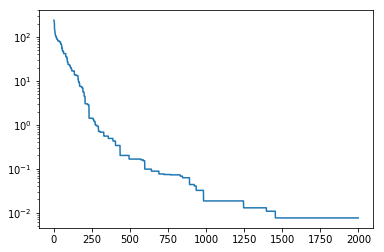

In [198]:
init_pop=copy(population)
print("Starting GA:")
func='rastrigins'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

## Shifted Rastrigins Comparison for PSO and GA

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


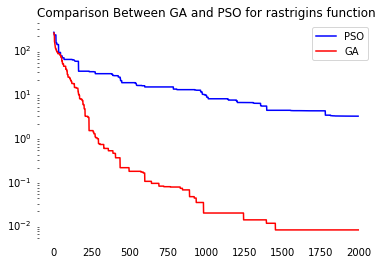

In [200]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Griewanks Function PSO

Starting PSO:
Epoch = 100 Global Best error= 0.6275419464476104
Epoch = 200 Global Best error= 0.5823370723074999
Epoch = 300 Global Best error= 0.4657920121528828
Epoch = 400 Global Best error= 0.4657920121528828
Epoch = 500 Global Best error= 0.4657920121528828
Epoch = 600 Global Best error= 0.4657920121528828
Epoch = 700 Global Best error= 0.15795009083190226
Epoch = 800 Global Best error= 0.10764654305903298
Epoch = 900 Global Best error= 0.10199047088292279
Epoch = 1000 Global Best error= 0.10105216721200527
Epoch = 1100 Global Best error= 0.10097022427514024
Epoch = 1200 Global Best error= 0.10094603273772795
Epoch = 1300 Global Best error= 0.08133398268653869
Epoch = 1400 Global Best error= 0.08126920857941577
Epoch = 1500 Global Best error= 0.08124179203269732
Epoch = 1600 Global Best error= 0.08121863056381273
Epoch = 1700 Global Best error= 0.08121471280183856
Epoch = 1800 Global Best error= 0.08121426050895275
Epoch = 1900 Global Best error= 0.08120663561851682
Final Global 

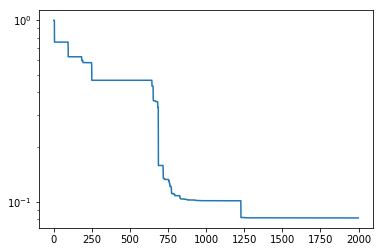

In [206]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_Griewanks,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## Shifted Griewanks Function GA

Starting GA:
Best result in generation 0 is 0.9942864475691977
Best result in generation 100 is 0.060481084471211366
Best result in generation 200 is 0.059903410852113925
Best result in generation 300 is 0.059458805804480375
Best result in generation 400 is 0.059172801388236884
Best result in generation 500 is 0.059135794146312426
Best result in generation 600 is 0.05912225973584828
Best result in generation 700 is 0.05911386028362131
Best result in generation 800 is 0.05911386028362131
Best result in generation 900 is 0.05910729705702511
Best result in generation 1000 is 0.059107233441126894
Best result in generation 1100 is 0.05910479873024699
Best result in generation 1200 is 0.05910457407826586
Best result in generation 1300 is 0.05910457407826586
Best result in generation 1400 is 0.05909927301020579
Best result in generation 1500 is 0.05909927301020579
Best result in generation 1600 is 0.05909715150842432
Best result in generation 1700 is 0.05909715150842432
Best result in generat

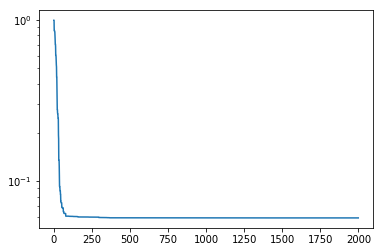

In [205]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_Griewanks'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

## Comparison of Shifted Griewanks in PSO and GA

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


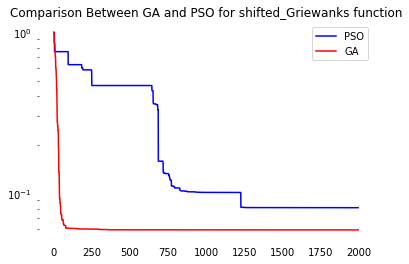

In [207]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Rosenbrock Function PSO

Starting PSO:
Epoch = 100 Global Best error= 17334.28882811685
Epoch = 200 Global Best error= 2358.2902340373403
Epoch = 300 Global Best error= 731.2964142479109
Epoch = 400 Global Best error= 205.68565208849282
Epoch = 500 Global Best error= 61.97638236468412
Epoch = 600 Global Best error= 45.433419556645426
Epoch = 700 Global Best error= 11.476526570840683
Epoch = 800 Global Best error= 9.048481456975747
Epoch = 900 Global Best error= 8.948088739019996
Epoch = 1000 Global Best error= 8.786605507919422
Epoch = 1100 Global Best error= 8.786605507919422
Epoch = 1200 Global Best error= 8.721030664476007
Epoch = 1300 Global Best error= 8.543109235662756
Epoch = 1400 Global Best error= 8.448310478520241
Epoch = 1500 Global Best error= 8.399665704794689
Epoch = 1600 Global Best error= 8.164449531209183
Epoch = 1700 Global Best error= 8.11495943348785
Epoch = 1800 Global Best error= 8.046616939019799
Epoch = 1900 Global Best error= 8.004741040869957
Final Global Best Position And Correspondi

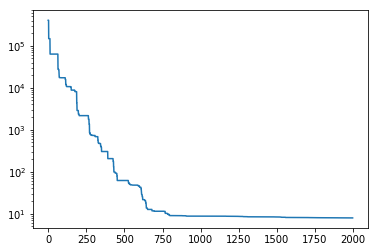

In [165]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_Rosenbrock,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## Shifted Rosenbrock Function GA

Starting GA:
Best result in generation 0 is 405833.73319595854
Best result in generation 100 is 79.10675264214399
Best result in generation 200 is 24.14529057158712
Best result in generation 300 is 9.321722219227953
Best result in generation 400 is 8.514635774599295
Best result in generation 500 is 8.184883961295041
Best result in generation 600 is 8.184883961295041
Best result in generation 700 is 8.160750158091489
Best result in generation 800 is 8.133023805829813
Best result in generation 900 is 8.118240577723812
Best result in generation 1000 is 8.102621364320369
Best result in generation 1100 is 8.102455089917797
Best result in generation 1200 is 8.089127760707804
Best result in generation 1300 is 8.089127760707804
Best result in generation 1400 is 8.089127760707804
Best result in generation 1500 is 8.073025632502272
Best result in generation 1600 is 8.024491022304314
Best result in generation 1700 is 8.024491022304314
Best result in generation 1800 is 8.024491022304314
Best resul

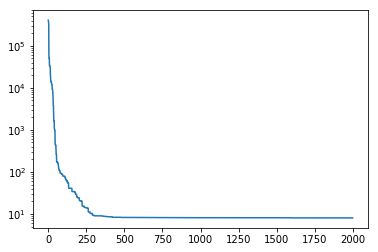

In [194]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_Rosenbrock'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

## Shifted Rosenbrock Comparison of PSO and GA

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


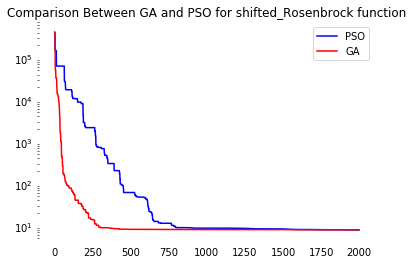

In [195]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Checking the effect on comparison with the population dimension = 20

In [250]:
np.random.seed(59)
population=np.random.uniform(low=-10.0, high=10.0, size=(20,20))

## PSO Rastrigin's Dimension=20

Starting PSO:
Epoch = 100 Global Best error= 270.59759713842
Epoch = 200 Global Best error= 215.6323520063116
Epoch = 300 Global Best error= 136.79475253299836
Epoch = 400 Global Best error= 126.67623310643414
Epoch = 500 Global Best error= 112.88024075956758
Epoch = 600 Global Best error= 93.80341562210005
Epoch = 700 Global Best error= 88.46214744104381
Epoch = 800 Global Best error= 63.183732332939336
Epoch = 900 Global Best error= 56.15378771353142
Epoch = 1000 Global Best error= 51.67930739197732
Epoch = 1100 Global Best error= 45.09971739257123
Epoch = 1200 Global Best error= 37.32522881595165
Epoch = 1300 Global Best error= 26.86446450711857
Epoch = 1400 Global Best error= 24.219980668951365
Epoch = 1500 Global Best error= 22.632556862031738
Epoch = 1600 Global Best error= 18.793086791178776
Epoch = 1700 Global Best error= 17.135397719782027
Epoch = 1800 Global Best error= 15.375946402085274
Epoch = 1900 Global Best error= 13.244407310806087
Final Global Best Position And Corres

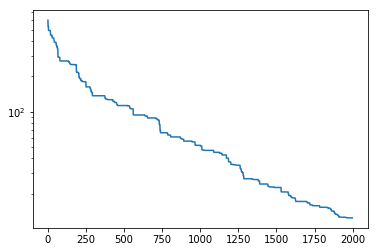

In [226]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(rastrigins,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## GA Rastrigin's Dimension=20

Starting GA:
Best result in generation 0 is 556.8525507164625
Best result in generation 100 is 177.5469519595216
Best result in generation 200 is 84.09432811554468
Best result in generation 300 is 42.806861815352924
Best result in generation 400 is 18.932240039079318
Best result in generation 500 is 9.717631731514508
Best result in generation 600 is 4.9218517549423755
Best result in generation 700 is 2.9567999375633818
Best result in generation 800 is 2.0781824443927963
Best result in generation 900 is 1.365989753961978
Best result in generation 1000 is 0.8282446173653035
Best result in generation 1100 is 0.599290591092208
Best result in generation 1200 is 0.5072537836045061
Best result in generation 1300 is 0.46060639808432136
Best result in generation 1400 is 0.35143868547833357
Best result in generation 1500 is 0.3088683826277805
Best result in generation 1600 is 0.2745220192288791
Best result in generation 1700 is 0.23748955918318693
Best result in generation 1800 is 0.206537095302

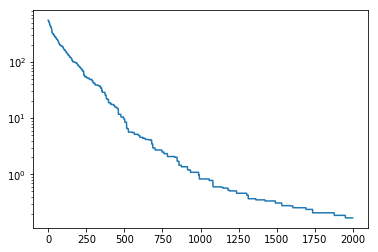

In [227]:
init_pop=copy(population)
print("Starting GA:")
func='rastrigins'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


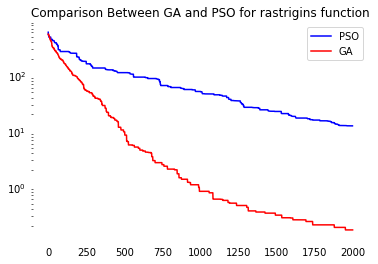

In [228]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## PSO-Shifted Griewanks with dimension=20

Starting PSO:
Epoch = 100 Global Best error= 1.0738790041999147
Epoch = 200 Global Best error= 1.0241753837701333
Epoch = 300 Global Best error= 1.0018716325506951
Epoch = 400 Global Best error= 0.9912695019606277
Epoch = 500 Global Best error= 0.9775611655471149
Epoch = 600 Global Best error= 0.7307913044810574
Epoch = 700 Global Best error= 0.6997594860270838
Epoch = 800 Global Best error= 0.6370846166387025
Epoch = 900 Global Best error= 0.42979906901062936
Epoch = 1000 Global Best error= 0.3314525371485285
Epoch = 1100 Global Best error= 0.21985155249305277
Epoch = 1200 Global Best error= 0.16373113427432173
Epoch = 1300 Global Best error= 0.13802030854714464
Epoch = 1400 Global Best error= 0.08861757981608454
Epoch = 1500 Global Best error= 0.07753799055677624
Epoch = 1600 Global Best error= 0.07387797606965185
Epoch = 1700 Global Best error= 0.07154194427742044
Epoch = 1800 Global Best error= 0.06766925588140316
Epoch = 1900 Global Best error= 0.06623207808985843
Final Global Bes

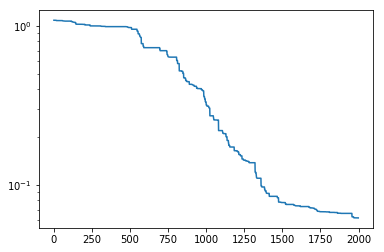

In [248]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_Griewanks,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## GA-Shifted Griewanks with Size=20,Dimension=20

Starting GA:
Best result in generation 0 is 1.087380340713731
Best result in generation 100 is 0.808682054757541
Best result in generation 200 is 0.44415428619284525
Best result in generation 300 is 0.24682699715426049
Best result in generation 400 is 0.12120521828783226
Best result in generation 500 is 0.09919436347524369
Best result in generation 600 is 0.07742847702311928
Best result in generation 700 is 0.06585960300964644
Best result in generation 800 is 0.05451897831426045
Best result in generation 900 is 0.04231383397195709
Best result in generation 1000 is 0.0408093504057605
Best result in generation 1100 is 0.03919886457290689
Best result in generation 1200 is 0.03492331530808235
Best result in generation 1300 is 0.03340597981934401
Best result in generation 1400 is 0.029587677543175595
Best result in generation 1500 is 0.028143665976883003
Best result in generation 1600 is 0.025636039569032043
Best result in generation 1700 is 0.024514128049430206
Best result in generation 18

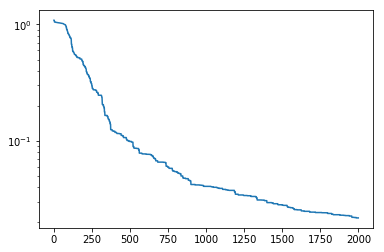

In [246]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_Griewanks'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


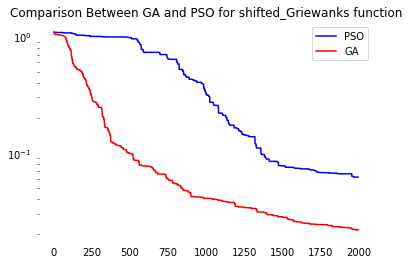

In [249]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## PSO Shifted Rosenbrock Dimension=20

Starting PSO:
Epoch = 100 Global Best error= 632208.6556920967
Epoch = 200 Global Best error= 535357.1357095026
Epoch = 300 Global Best error= 252422.39629066916
Epoch = 400 Global Best error= 107575.51651063391
Epoch = 500 Global Best error= 57406.289358084105
Epoch = 600 Global Best error= 39457.70438635134
Epoch = 700 Global Best error= 6480.025887842836
Epoch = 800 Global Best error= 4872.001353976548
Epoch = 900 Global Best error= 2705.7400997651766
Epoch = 1000 Global Best error= 525.9533619247919
Epoch = 1100 Global Best error= 438.790575687476
Epoch = 1200 Global Best error= 335.20907039410537
Epoch = 1300 Global Best error= 262.0263999156688
Epoch = 1400 Global Best error= 137.4335208973851
Epoch = 1500 Global Best error= 131.2034082630662
Epoch = 1600 Global Best error= 105.56271909963483
Epoch = 1700 Global Best error= 100.20137716434463
Epoch = 1800 Global Best error= 93.01589396821174
Epoch = 1900 Global Best error= 83.48940324139475
Final Global Best Position And Correspo

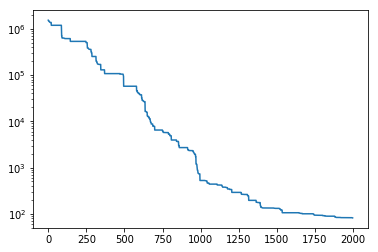

In [251]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_Rosenbrock,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

## GA Shifted Rosenbrock Dimension=20

Starting GA:
Best result in generation 0 is 1150342.1255995624
Best result in generation 100 is 141990.33576757353
Best result in generation 200 is 21960.221212584624
Best result in generation 300 is 9230.966594780255
Best result in generation 400 is 5511.470085404915
Best result in generation 500 is 3190.7034687899795
Best result in generation 600 is 1460.4857599896227
Best result in generation 700 is 957.436987541112
Best result in generation 800 is 632.330268725397
Best result in generation 900 is 474.6413068401108
Best result in generation 1000 is 361.66856898152946
Best result in generation 1100 is 306.5425901761279
Best result in generation 1200 is 267.1923134401693
Best result in generation 1300 is 249.64221403418074
Best result in generation 1400 is 224.4982942632139
Best result in generation 1500 is 213.91946614445519
Best result in generation 1600 is 205.8333859066921
Best result in generation 1700 is 180.19332559398447
Best result in generation 1800 is 150.15432994923577
Bes

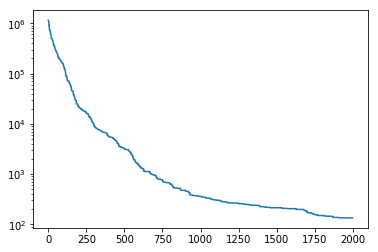

In [254]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_Rosenbrock'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


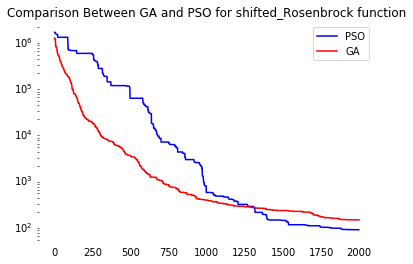

In [255]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Sphere Dimension=20

Starting PSO:
Epoch = 100 Global Best error= 67.11406093424021
Epoch = 200 Global Best error= 19.96171128220021
Epoch = 300 Global Best error= 4.64739965755073
Epoch = 400 Global Best error= 4.169976810929315
Epoch = 500 Global Best error= 2.2688079838690194
Epoch = 600 Global Best error= 1.1103913618758325
Epoch = 700 Global Best error= 0.607647241438868
Epoch = 800 Global Best error= 0.2902877502214348
Epoch = 900 Global Best error= 0.12001341766881635
Epoch = 1000 Global Best error= 0.018686401465503585
Epoch = 1100 Global Best error= 0.006310019256225816
Epoch = 1200 Global Best error= 0.002341707883021511
Epoch = 1300 Global Best error= 0.0003899862687638804
Epoch = 1400 Global Best error= 0.000168132287906599
Epoch = 1500 Global Best error= 0.00011670211971342003
Epoch = 1600 Global Best error= 1.51331832886995e-05
Epoch = 1700 Global Best error= 1.0117627168045592e-05
Epoch = 1800 Global Best error= 3.1729097156172193e-06
Epoch = 1900 Global Best error= 1.5493638245820397e-06
Fi

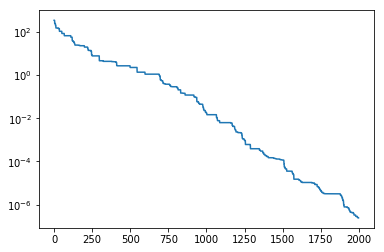

In [271]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_sphere,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

Starting GA:
Best result in generation 0 is 349.5275398310933
Best result in generation 100 is 91.12129934445885
Best result in generation 200 is 31.243472136715162
Best result in generation 300 is 19.543174678845894
Best result in generation 400 is 15.024394182287242
Best result in generation 500 is 12.838695815091844
Best result in generation 600 is 11.02530762686167
Best result in generation 700 is 9.262254720606993
Best result in generation 800 is 7.713933896380329
Best result in generation 900 is 6.5125180976809585
Best result in generation 1000 is 5.935276196533605
Best result in generation 1100 is 5.495898633624265
Best result in generation 1200 is 5.031698397993126
Best result in generation 1300 is 4.643226275699707
Best result in generation 1400 is 4.303914930310515
Best result in generation 1500 is 3.806458000010201
Best result in generation 1600 is 3.580019170524105
Best result in generation 1700 is 3.153559855410785
Best result in generation 1800 is 2.6868619850344144
Best 

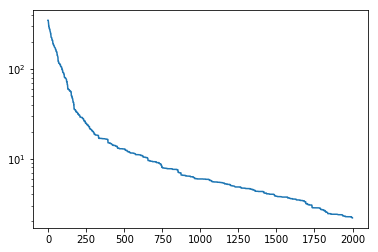

In [272]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_sphere'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


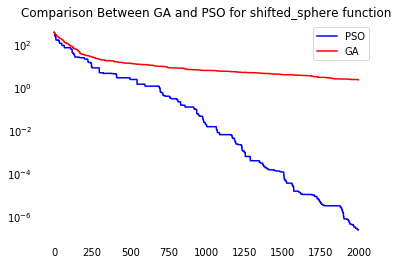

In [273]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Shifted Schwefel Dimension=20

Starting PSO:
Epoch = 100 Global Best error= 709.5691000876913
Epoch = 200 Global Best error= 410.97373489021606
Epoch = 300 Global Best error= 410.97373489021606
Epoch = 400 Global Best error= 389.15075520292004
Epoch = 500 Global Best error= 378.8943124716276
Epoch = 600 Global Best error= 378.8943124716276
Epoch = 700 Global Best error= 378.8943124716276
Epoch = 800 Global Best error= 278.1817813749232
Epoch = 900 Global Best error= 213.1149078669985
Epoch = 1000 Global Best error= 205.44002134606873
Epoch = 1100 Global Best error= 193.742094764557
Epoch = 1200 Global Best error= 150.21145053782303
Epoch = 1300 Global Best error= 102.7031554545114
Epoch = 1400 Global Best error= 102.7031554545114
Epoch = 1500 Global Best error= 102.7031554545114
Epoch = 1600 Global Best error= 102.7031554545114
Epoch = 1700 Global Best error= 69.37997536351972
Epoch = 1800 Global Best error= 60.780982207061435
Epoch = 1900 Global Best error= 39.25420846901042
Final Global Best Position And Correspon

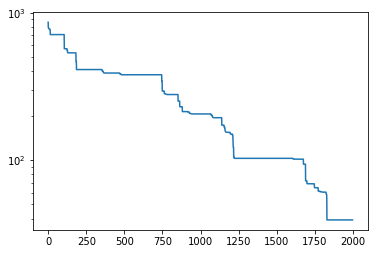

In [275]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_schwefel,init_pop,maxiter=2000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

Starting GA:
Best result in generation 0 is 549.7157000165305
Best result in generation 100 is 299.186698194596
Best result in generation 200 is 276.0870428631658
Best result in generation 300 is 257.6039708427852
Best result in generation 400 is 245.15395419191518
Best result in generation 500 is 230.02523072900598
Best result in generation 600 is 221.50471967016716
Best result in generation 700 is 216.647016599588
Best result in generation 800 is 212.6546826645708
Best result in generation 900 is 211.08904805902608
Best result in generation 1000 is 203.27399763636055
Best result in generation 1100 is 199.54225714700084
Best result in generation 1200 is 196.02199084965866
Best result in generation 1300 is 193.10725081495343
Best result in generation 1400 is 190.39946490520308
Best result in generation 1500 is 189.47830223826566
Best result in generation 1600 is 186.3297185265206
Best result in generation 1700 is 181.99201268332644
Best result in generation 1800 is 179.5458818490747
Be

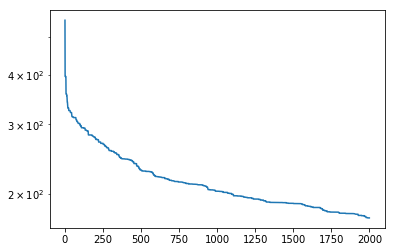

In [276]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_schwefel'
num_generations = 2000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


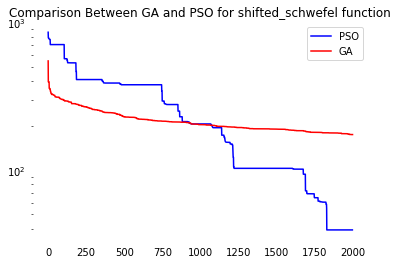

In [277]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Increasing number of iterations as 5000- For Rastrigin's

Starting PSO:
Epoch = 100 Global Best error= 320.4271646736509
Epoch = 200 Global Best error= 219.3126077654114
Epoch = 300 Global Best error= 173.15006325555288
Epoch = 400 Global Best error= 173.15006325555288
Epoch = 500 Global Best error= 153.44248528773656
Epoch = 600 Global Best error= 127.57790869855091
Epoch = 700 Global Best error= 110.34939987067955
Epoch = 800 Global Best error= 109.41054368424683
Epoch = 900 Global Best error= 89.81634435391636
Epoch = 1000 Global Best error= 81.20263919692586
Epoch = 1100 Global Best error= 79.86259992689483
Epoch = 1200 Global Best error= 78.55071034926759
Epoch = 1300 Global Best error= 75.25419129370886
Epoch = 1400 Global Best error= 75.25419129370886
Epoch = 1500 Global Best error= 68.7053127996397
Epoch = 1600 Global Best error= 61.7120363974584
Epoch = 1700 Global Best error= 57.475740404827995
Epoch = 1800 Global Best error= 53.72817618664755
Epoch = 1900 Global Best error= 50.04598515065918
Epoch = 2000 Global Best error= 46.40212

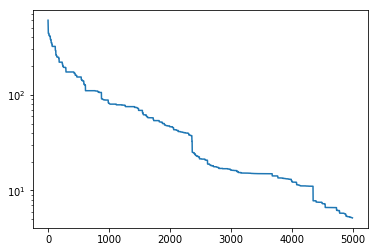

In [280]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(rastrigins,init_pop,maxiter=5000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

Starting GA:
Best result in generation 0 is 579.4724381436409
Best result in generation 100 is 230.07366772906323
Best result in generation 200 is 193.6647559321737
Best result in generation 300 is 172.78828029780726
Best result in generation 400 is 169.7146112637076
Best result in generation 500 is 164.8057923831546
Best result in generation 600 is 160.31725851904406
Best result in generation 700 is 155.82676455451877
Best result in generation 800 is 153.75567627631355
Best result in generation 900 is 153.6280133842374
Best result in generation 1000 is 152.98432157876806
Best result in generation 1100 is 143.2530337856409
Best result in generation 1200 is 139.7585827235568
Best result in generation 1300 is 132.42603145149386
Best result in generation 1400 is 130.1344194056256
Best result in generation 1500 is 127.17726355329195
Best result in generation 1600 is 125.68089537862181
Best result in generation 1700 is 124.94229290627892
Best result in generation 1800 is 123.00668966985936


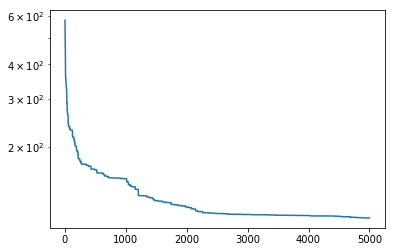

In [282]:
init_pop=copy(population)
print("Starting GA:")
func='rastrigins'
num_generations = 5000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


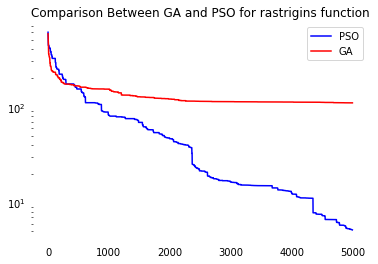

In [283]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()

## Increasing number of iterations as 5000-For Griewank's


Starting PSO:
Epoch = 100 Global Best error= 1.0390569050710095
Epoch = 200 Global Best error= 1.0171963632831826
Epoch = 300 Global Best error= 1.0001114541798253
Epoch = 400 Global Best error= 0.7537854655925696
Epoch = 500 Global Best error= 0.5005581499999772
Epoch = 600 Global Best error= 0.3486857391963353
Epoch = 700 Global Best error= 0.3486857391963353
Epoch = 800 Global Best error= 0.3486857391963353
Epoch = 900 Global Best error= 0.25628737346797803
Epoch = 1000 Global Best error= 0.16011022736472003
Epoch = 1100 Global Best error= 0.0813052523286012
Epoch = 1200 Global Best error= 0.051969695993734244
Epoch = 1300 Global Best error= 0.021576778183098666
Epoch = 1400 Global Best error= 0.013145215808010646
Epoch = 1500 Global Best error= 0.011115750670127933
Epoch = 1600 Global Best error= 0.010384278449477202
Epoch = 1700 Global Best error= 0.008855852714748758
Epoch = 1800 Global Best error= 0.008505031421343068
Epoch = 1900 Global Best error= 0.008122599743893955
Epoch = 

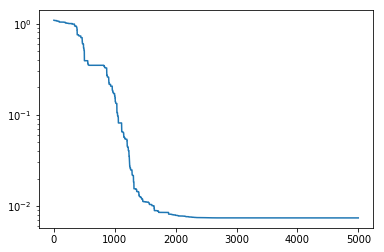

In [284]:
init_pop=copy(population)
print("Starting PSO:")
#Functions to use are rastrigins,shifted_sphere,shifted_schwefel,shifted_Griewanks,shifted_Rosenbrock,
obj=PSO(shifted_Griewanks,init_pop,maxiter=5000)
Error_PSO=obj.start_opt_PSO()
plt.semilogy(Error_PSO)
plt.show()

Starting GA:
Best result in generation 0 is 1.087380340713731
Best result in generation 100 is 0.7696473972614164
Best result in generation 200 is 0.39655984910095166
Best result in generation 300 is 0.2372107038109461
Best result in generation 400 is 0.18657511399635773
Best result in generation 500 is 0.16220335623343551
Best result in generation 600 is 0.1399499954134299
Best result in generation 700 is 0.10860653910114149
Best result in generation 800 is 0.10171896174152162
Best result in generation 900 is 0.09611827544810603
Best result in generation 1000 is 0.09383933773079467
Best result in generation 1100 is 0.08813339584004809
Best result in generation 1200 is 0.08252338325844821
Best result in generation 1300 is 0.08024170887407212
Best result in generation 1400 is 0.07986115331813015
Best result in generation 1500 is 0.07933974452555459
Best result in generation 1600 is 0.07827351411623584
Best result in generation 1700 is 0.0778169758001308
Best result in generation 1800 is

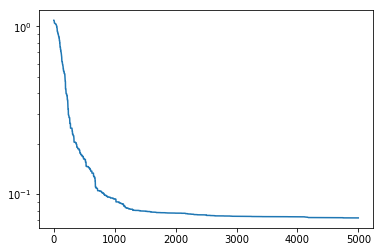

In [285]:
init_pop=copy(population)
print("Starting GA:")
func='shifted_Griewanks'
num_generations = 5000
obj_GA=GA(func,init_pop,num_generations,10)
GA_Error=obj_GA.start_opt_GA()
plt.semilogy(GA_Error)
plt.show()

C:\Users\mpfou\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


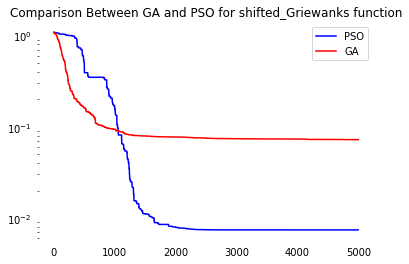

In [286]:
fig,ax=plt.subplots()
ax.semilogy(Error_PSO,c='blue',label='PSO')
ax.semilogy(GA_Error,c='red',label='GA')
ax.tick_params(bottom='off',top='off',left='off',right='off')
for key,spine in ax.spines.items():
    spine.set_visible(False)
ax.legend(loc='upper right') 
title='Comparison Between GA and PSO for '+func+' function'
ax.set_title(title)
plt.show()